4.Implement Bayes Classifier for Iris Dataset.

Dataset Specifications:

Total number of samples = 150

Number of classes = 3 (Iris setosa, Iris virginica, and Iris versicolor)

Number of samples in each class = 50

Use the following information to design classifier:

Number of training feature vectors ( first 40 in each class) = 40

Number of test feature vectors ( remaining 10 in each class) = 10

Number of dimensions = 4

Feature vector = <sepal length, sepal width, petal length, petal width>

Use only two features: Petal Length and Petal Width, for 3 class classification and draw the decision 

boundary between them (2 dimension, 3 regions also called as multi-class problem)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Function to calculate mean and variance for each class
def calculate_mean_variance(training_df, labels, n):
    mean = np.zeros((n, training_df.shape[1]))
    var = np.zeros((n, training_df.shape[1]))
    
    for i in range(n):
        classi = training_df[labels == i]
        mean[i, :] = np.mean(classi, axis=0)
        var[i, :] = np.var(classi, axis=0)
    
    return mean, var

# Function to calculate Gaussian probability
def gaussian_probability(x, mean, var):
    exponent = np.exp(-((x - mean) ** 2) / (2 * var))
    return (1 / np.sqrt(2 * np.pi * var)) * exponent

# Bayes classifier
def bayes_classifier(X, mean, var, n):
    pw = 1 / n
    prob = np.zeros((X.shape[0], n))
    
    for i in range(n):
        likelihood = gaussian_probability(X, mean[i], var[i]).prod(axis=1)
        prob[:, i] = likelihood * pw
    
    return np.argmax(prob, axis=1)




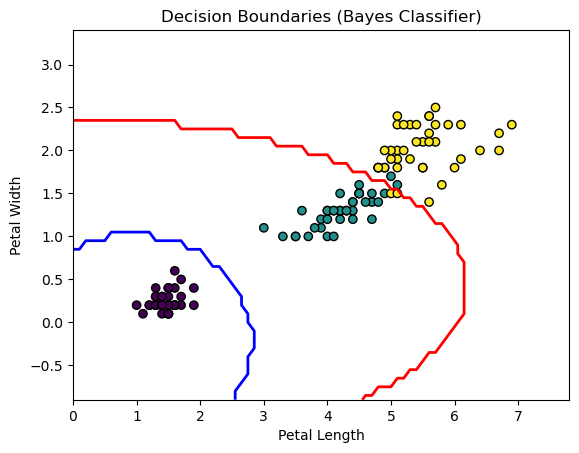

In [4]:
# Load iris dataset
iris_df = pd.read_csv('./iris.csv')

#Only two features
iris_df = iris_df[['PetalLengthCm', 'PetalWidthCm', 'Species']]

# Testing data: First 10 samples of each variety
test_df = []
for class_label in iris_df['Species'].unique():
    sample = iris_df[iris_df['Species'] == class_label].head(10)
    test_df.append(sample)

test_df = pd.concat(test_df)

n = 3
#Dropping testing dataset
training_df = iris_df.drop(test_df.index)

# Mapping species to integers: 'setosa' -> 0, 'versicolor' -> 1, 'virginica' -> 2
species_map = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
labels = training_df['Species'].map(species_map).values
training_df.drop(columns = [ 'Species'], inplace = True)

# Calculating mean and variance for training data
mean, var = calculate_mean_variance(training_df, labels, n)

# For plotting decision boundaries
x_min, x_max = training_df.iloc[:, 0].min() - 1, training_df.iloc[:, 0].max() + 1
y_min, y_max = training_df.iloc[:, 1].min() - 1, training_df.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
grid = np.c_[xx.ravel(), yy.ravel()]

# Classifying the grid points
result = bayes_classifier(grid, mean, var, n)
result = result.reshape(xx.shape)

# Plotting decision boundaries

plt.contour(xx, yy, result, levels=[0.5, 1.5], colors=['blue', 'red'], linewidths=2)
plt.scatter(training_df.iloc[:, 0], training_df.iloc[:, 1], c=labels, edgecolor='k', marker='o')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('Decision Boundaries (Bayes Classifier)')
plt.show()


In [5]:
# Mapping the test labels to integers for comparison
test_labels = test_df['Species'].map(species_map).values

# Dropping the 'Species' column from the test data, keeping only the features
test_features = test_df.drop(columns=['Species']).values

# Classifying the test data
test_predictions = bayes_classifier(test_features, mean, var, n)

# Calculating accuracy
accuracy = np.mean(test_predictions == test_labels) * 100
print(f'Accuracy of the Bayes Classifier: {accuracy}%')


Accuracy of the Bayes Classifier: 96.66666666666667%
